# Data processing

In [524]:
# common packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
# from datetime import date
%matplotlib inline

# data denoising
import pywt
import copy

# feature extraction
from ta.volume import AccDistIndexIndicator

### Useful function and common variables

In [525]:
DIAGRAMS_PATH = "./diagrams"
def parse_string_to_datetime(x):
    return datetime.strptime(x, '%Y-%m-%d')

def is_stock_hk(stock_name):
    return ".HK" in stock_name

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

### Read stock price CSVs

In [526]:
raw_marekt_data_path = "./data/raw/market_data/"

# current directory csv files;
#  ref: https://stackoverflow.com/a/55245949/9500852
csvs = [x for x in os.listdir(raw_marekt_data_path) if x.endswith('.csv')]
# stats.csv -> stats
fns = [os.path.splitext(os.path.basename(x))[0] for x in csvs]

d = {}
for i in range(len(fns)):
    d[fns[i]] = pd.read_csv(raw_marekt_data_path + csvs[i])

    # parse also the date from string to Datetime object
    if not isinstance(d[fns[i]]["Date"][0], datetime):
        d[fns[i]]["Date"] = d[fns[i]]["Date"].apply(parse_string_to_datetime)

# show read csv result - Disney's stock
d["DIS"]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2011-09-30,26.557592,27.041898,26.407898,26.557592,15135000,0.0,0
1,2011-10-03,26.443124,26.707291,25.527344,25.536150,13899200,0.0,0
2,2011-10-04,25.298400,26.390290,24.822900,26.293430,19000000,0.0,0
3,2011-10-05,26.724900,27.781567,26.689677,27.746346,17823700,0.0,0
4,2011-10-06,27.499790,28.221847,27.314874,28.204235,12659400,0.0,0
...,...,...,...,...,...,...,...,...
2512,2021-09-24,175.300003,176.699997,175.080002,176.000000,5712800,0.0,0
2513,2021-09-27,176.630005,179.449997,175.960007,178.259995,7755000,0.0,0
2514,2021-09-28,177.750000,178.000000,173.860001,174.520004,9133100,0.0,0
2515,2021-09-29,174.250000,174.960007,172.589996,172.679993,6240800,0.0,0


### Stock data count

In [527]:
hk_stock_row_count = 0
us_stock_row_count = 0

for i in range(len(fns)):
    if is_stock_hk(fns[i]):
        hk_stock_row_count = hk_stock_row_count + len(d[fns[i]])
    else:
        us_stock_row_count = us_stock_row_count + len(d[fns[i]])

print("Rows of HK stocks data: " + str(hk_stock_row_count))
print("Rows of US stocks data: " + str(us_stock_row_count))

Rows of HK stocks data: 121231
Rows of US stocks data: 123839


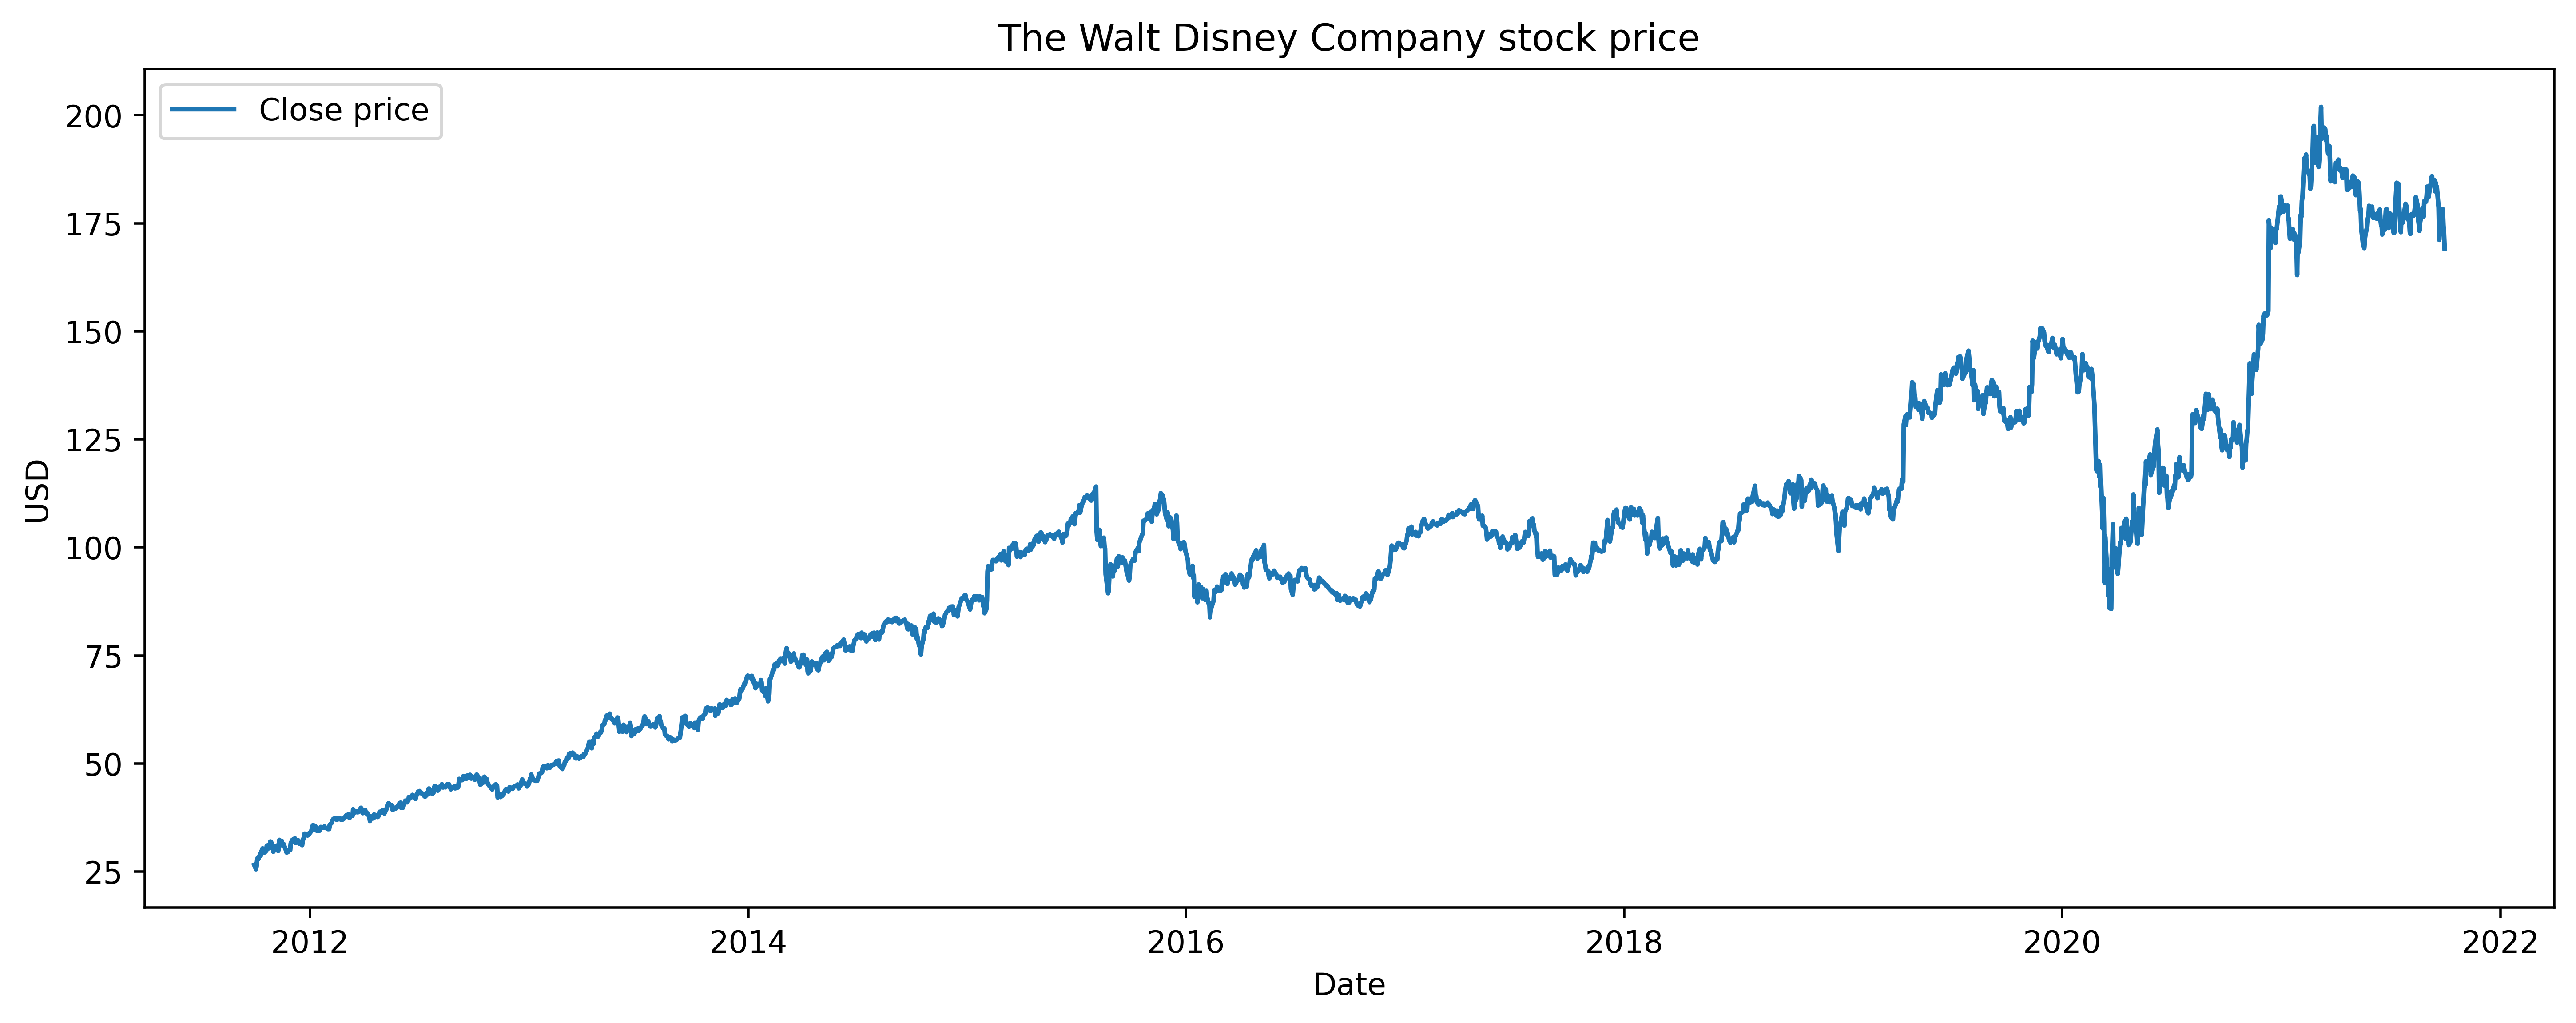

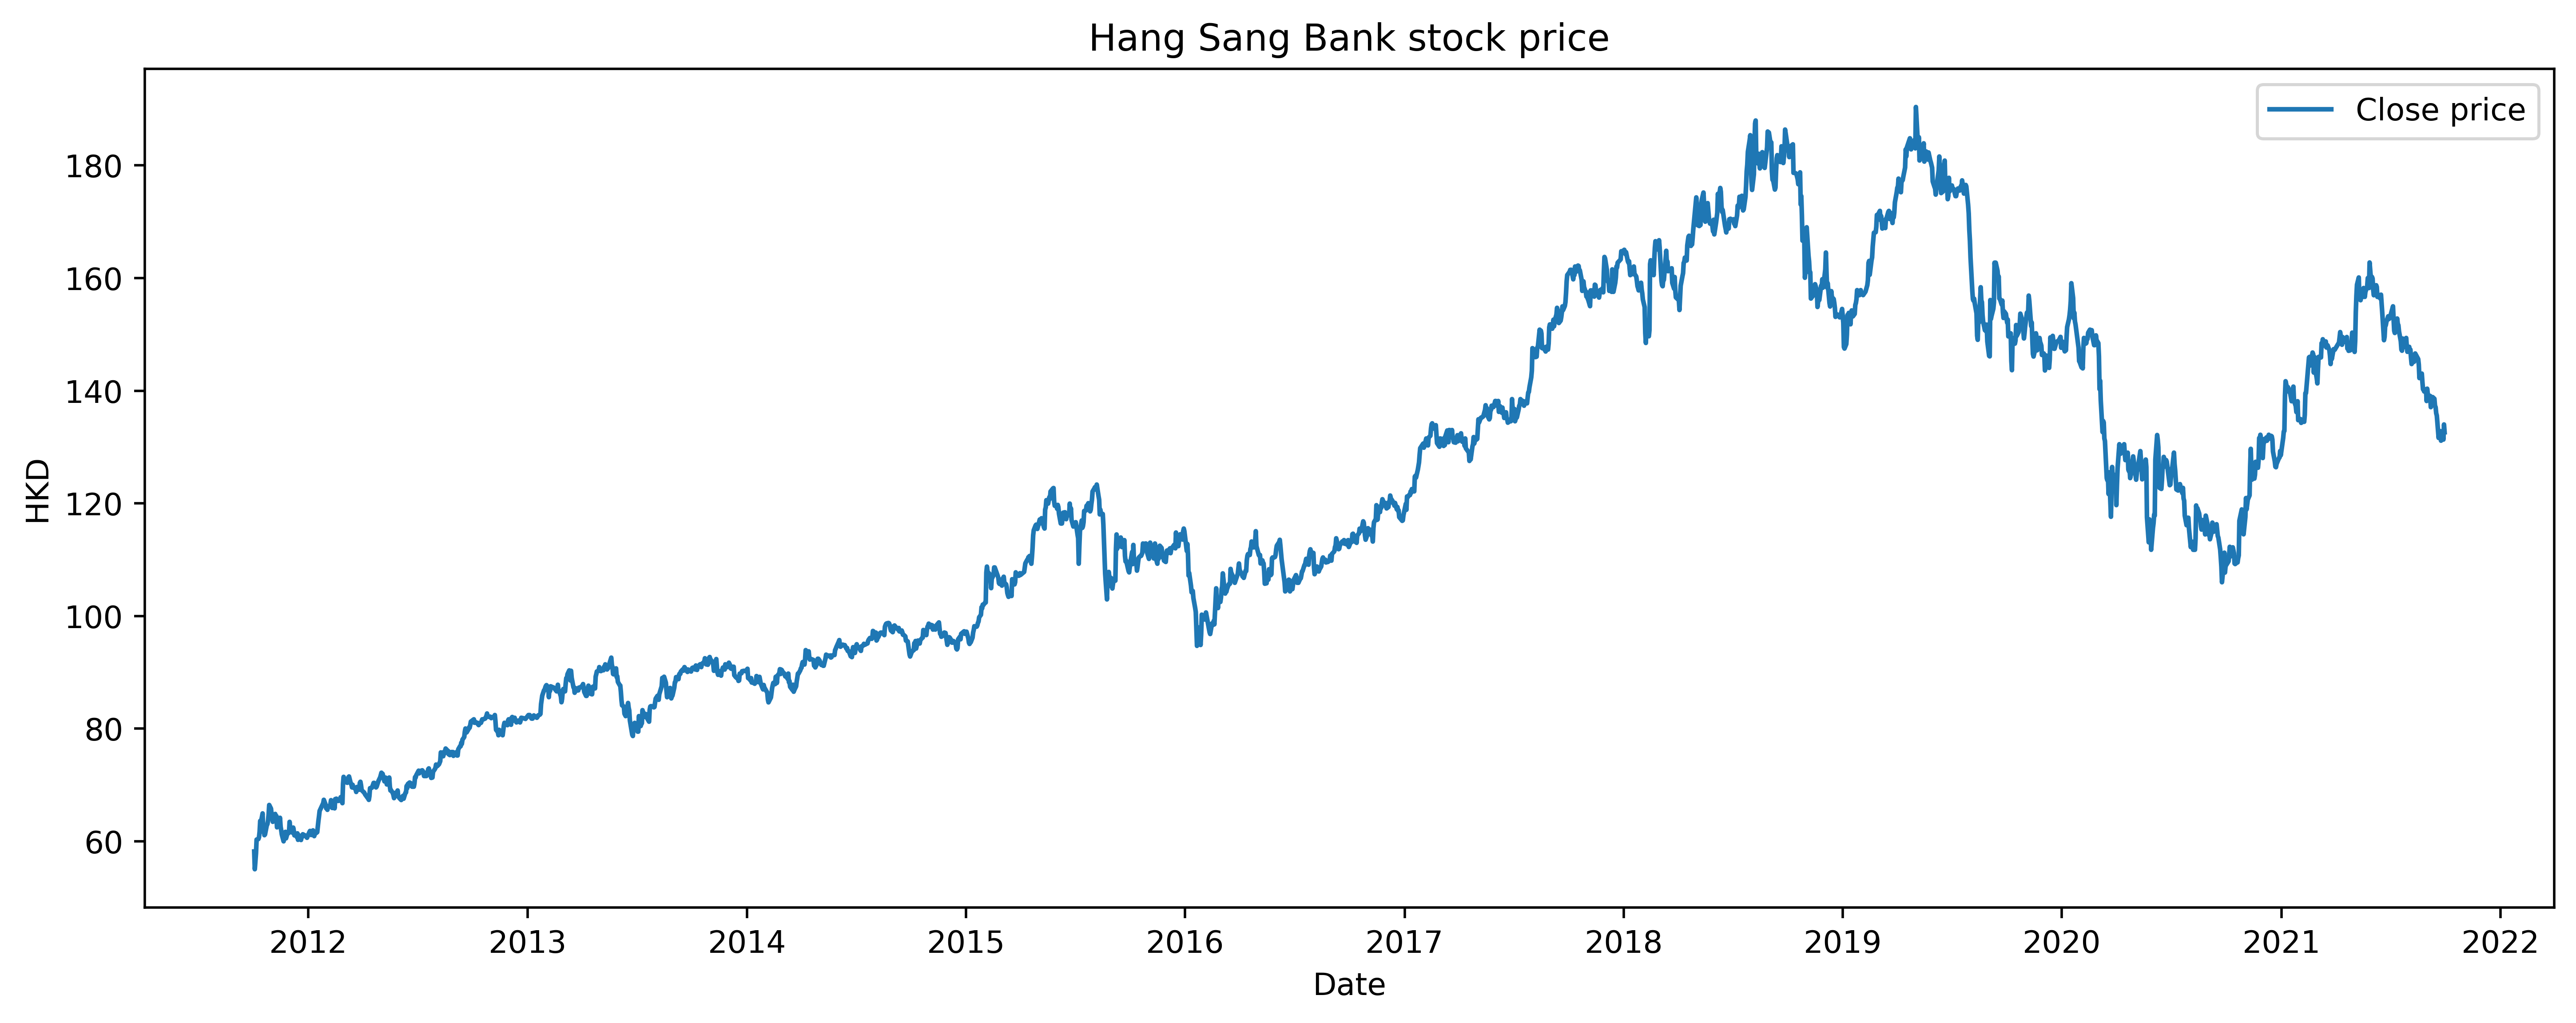

In [528]:
def plot_raw_stock_price(stock_id, title, legend_label, y_label):
    if not isinstance(d[stock_id]["Date"][0], datetime):
        d[stock_id]["Date"] = d[stock_id]["Date"].apply(parse_string_to_datetime)

    plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
    plt.plot(d[stock_id]['Date'], d[stock_id]['Close'], label=legend_label)
    # plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
    plt.show()

# plot The Walt Disney Company (DIS) stocks price
plot_raw_stock_price("DIS",
                     'The Walt Disney Company stock price',
                     'Close price',
                     'USD'
                )

# plot 0011.HK stocks price
plot_raw_stock_price("0011.HK",
                     'Hang Sang Bank stock price',
                     'Close price',
                     "HKD"
                    )

### Data denoising with 2-level discrete Wavelet Transform

In [529]:
def wavelet_denoise(index_list, wavefunc='haar', lv=2, m=1, n=2, plot=False):

    '''
    *** Reference **
    Obtained from: https://github.com/SunHao95/PHBS_TQFML-StockIndex-Wavelet-Transformation-ARIMA-ML-Model/blob/c1c3c11e80568663448bdc30f87dc378db0538d2/Project/model.py#L19-L68
    Edited to fit the project's requirements
    *** END ***

    WT: Wavelet Transformation Function
    index_list: Input Sequence;

    lv: Decomposing Level；

    wavefunc: Function of Wavelet, 'db4' default；

    m, n: Level of Threshold Processing

    '''

    # Decomposing
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function

    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])

    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]

    if plot:
        denoised_index = np.sum(coeff, axis=0)
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))
        print(data)

    return coeff

In [530]:
d_denoised = copy.deepcopy(d) # create copy from raw data to prevent overwrite
denoised_count = 0
for i in range(len(fns)):
    tmp_close_price = d_denoised[fns[i]]["Close"]
    coeff = wavelet_denoise(tmp_close_price)
    d_denoised[fns[i]]["Close"] = np.sum(coeff, axis=0) # reconstruct and save to the dataframe
    denoised_count = denoised_count + 1
    print("{} OK".format(fns[i]))

print("Denoised count: {}".format(denoised_count))

UAL OK
1109.HK OK
V OK
2313.HK OK
0027.HK OK
3968.HK OK
WU OK
MSI OK
FCX OK
0003.HK OK
ADM OK
0011.HK OK
GPN OK
0857.HK OK
ARE OK
0001.HK OK
0101.HK OK
FMC OK
AIZ OK
BXP OK
1398.HK OK
0005.HK OK
0941.HK OK
0066.HK OK
2331.HK OK
0017.HK OK
1093.HK OK
0388.HK OK
2319.HK OK
0762.HK OK
2628.HK OK
1044.HK OK
RL OK
0241.HK OK
FTNT OK
JNPR OK
DHI OK
2020.HK OK
EXPE OK
1928.HK OK
KO OK
WDC OK
LUMN OK
UPS OK
MSFT OK
UDR OK
COO OK
2018.HK OK
MLM OK
0267.HK OK
AMD OK
ZBH OK
0386.HK OK
UHS OK
SBAC OK
0002.HK OK
0669.HK OK
LKQ OK
PVH OK
3988.HK OK
GD OK
CLX OK
0688.HK OK
DIS OK
0883.HK OK
LDOS OK
LEN OK
2382.HK OK
AOS OK
OMC OK
1299.HK OK
TSLA OK
TXT OK
1177.HK OK
0012.HK OK
0939.HK OK
0960.HK OK
2388.HK OK
REGN OK
AMGN OK
TEL OK
IFF OK
1038.HK OK
ROST OK
0868.HK OK
2888.HK OK
0700.HK OK
2318.HK OK
0823.HK OK
0175.HK OK
0016.HK OK
TEAM OK
GPC OK
AAPL OK
1211.HK OK
0006.HK OK
EFX OK
WAB OK
2007.HK OK
NWL OK
Denoised count: 100


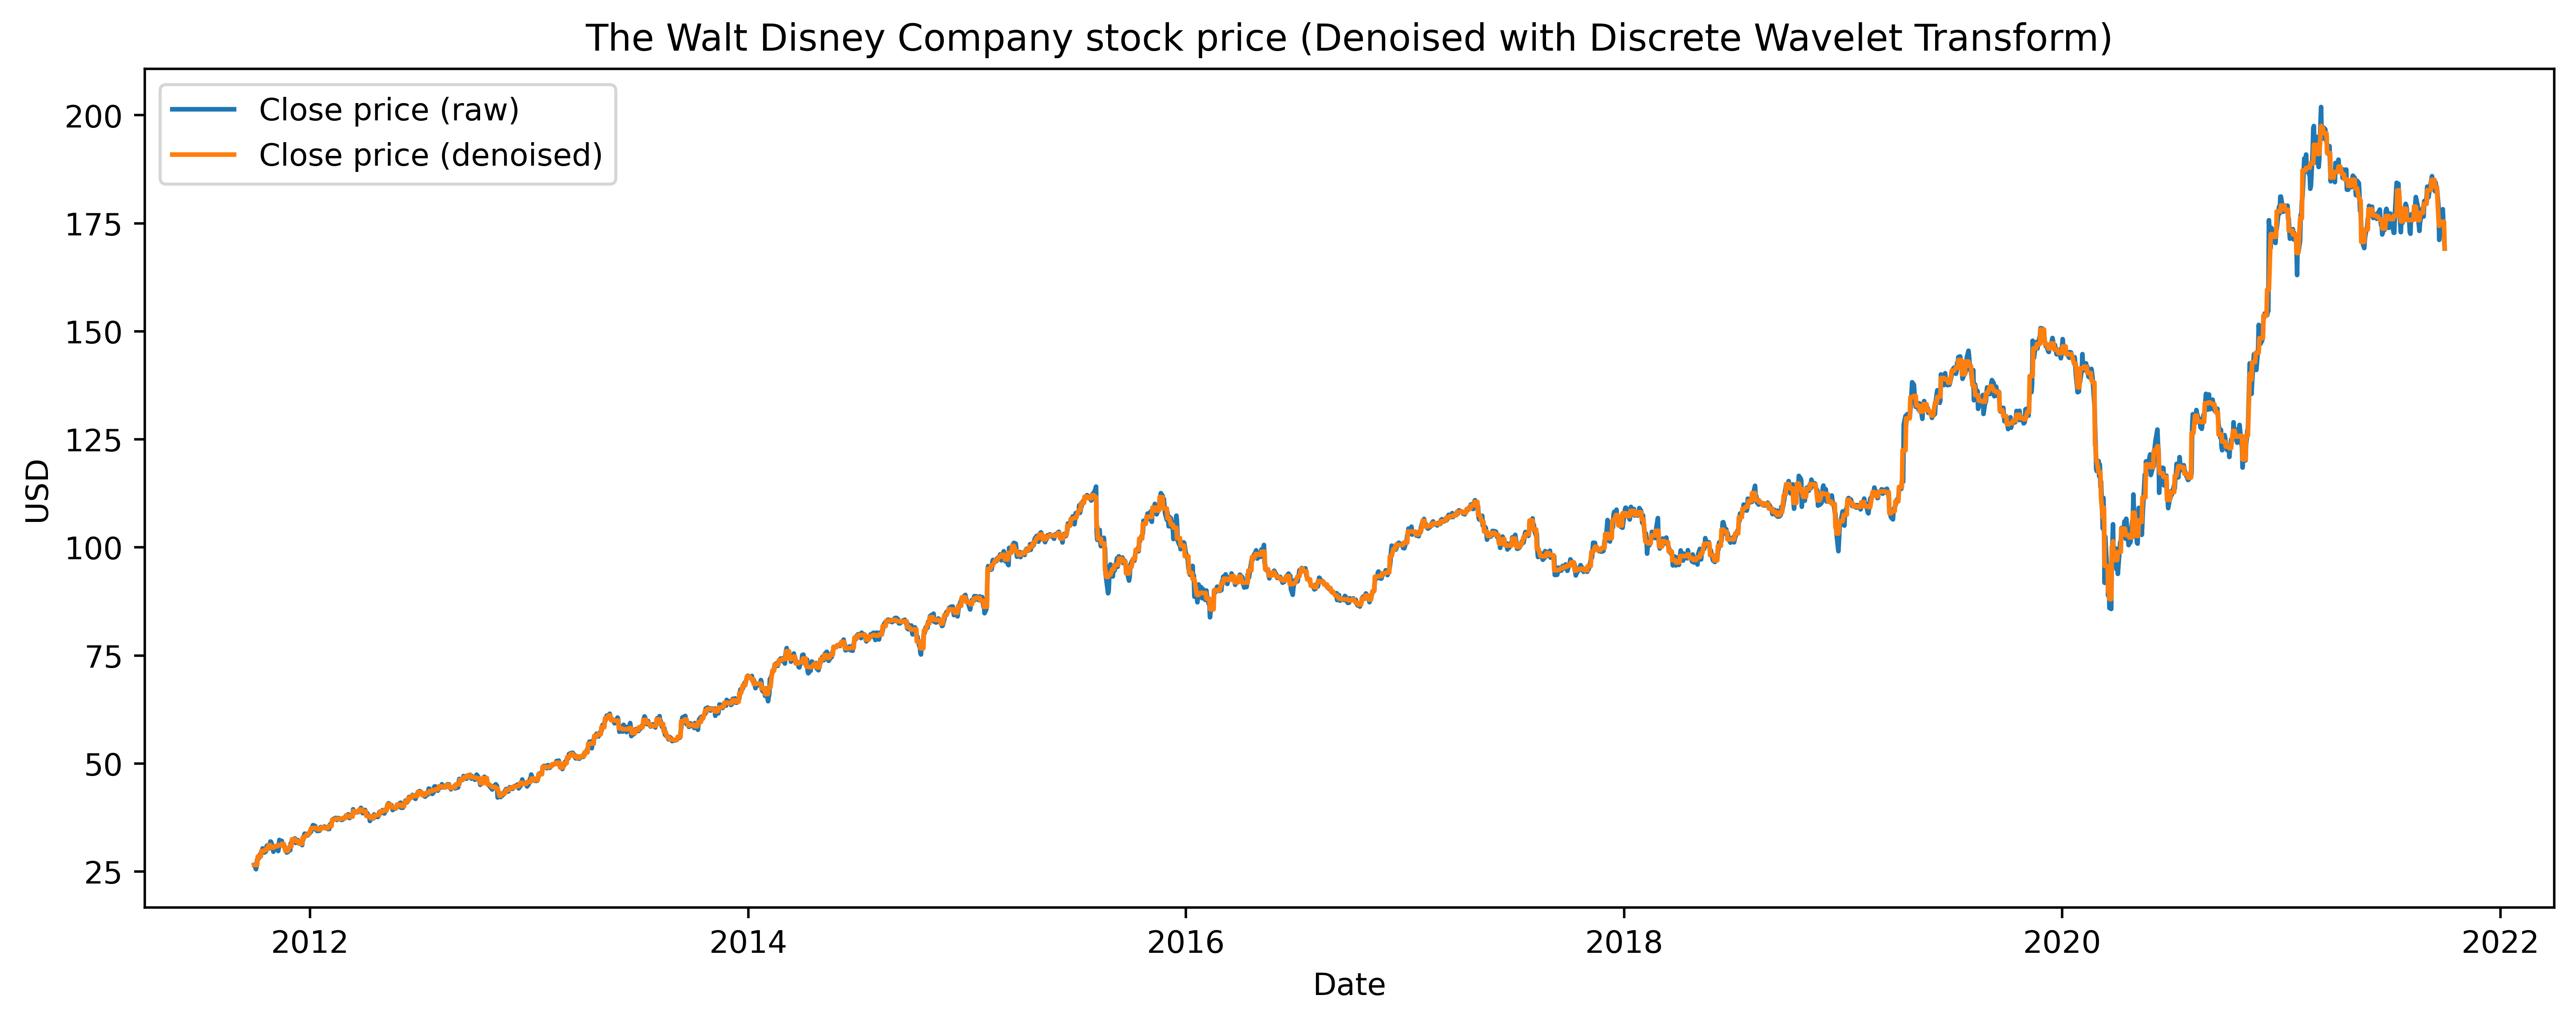

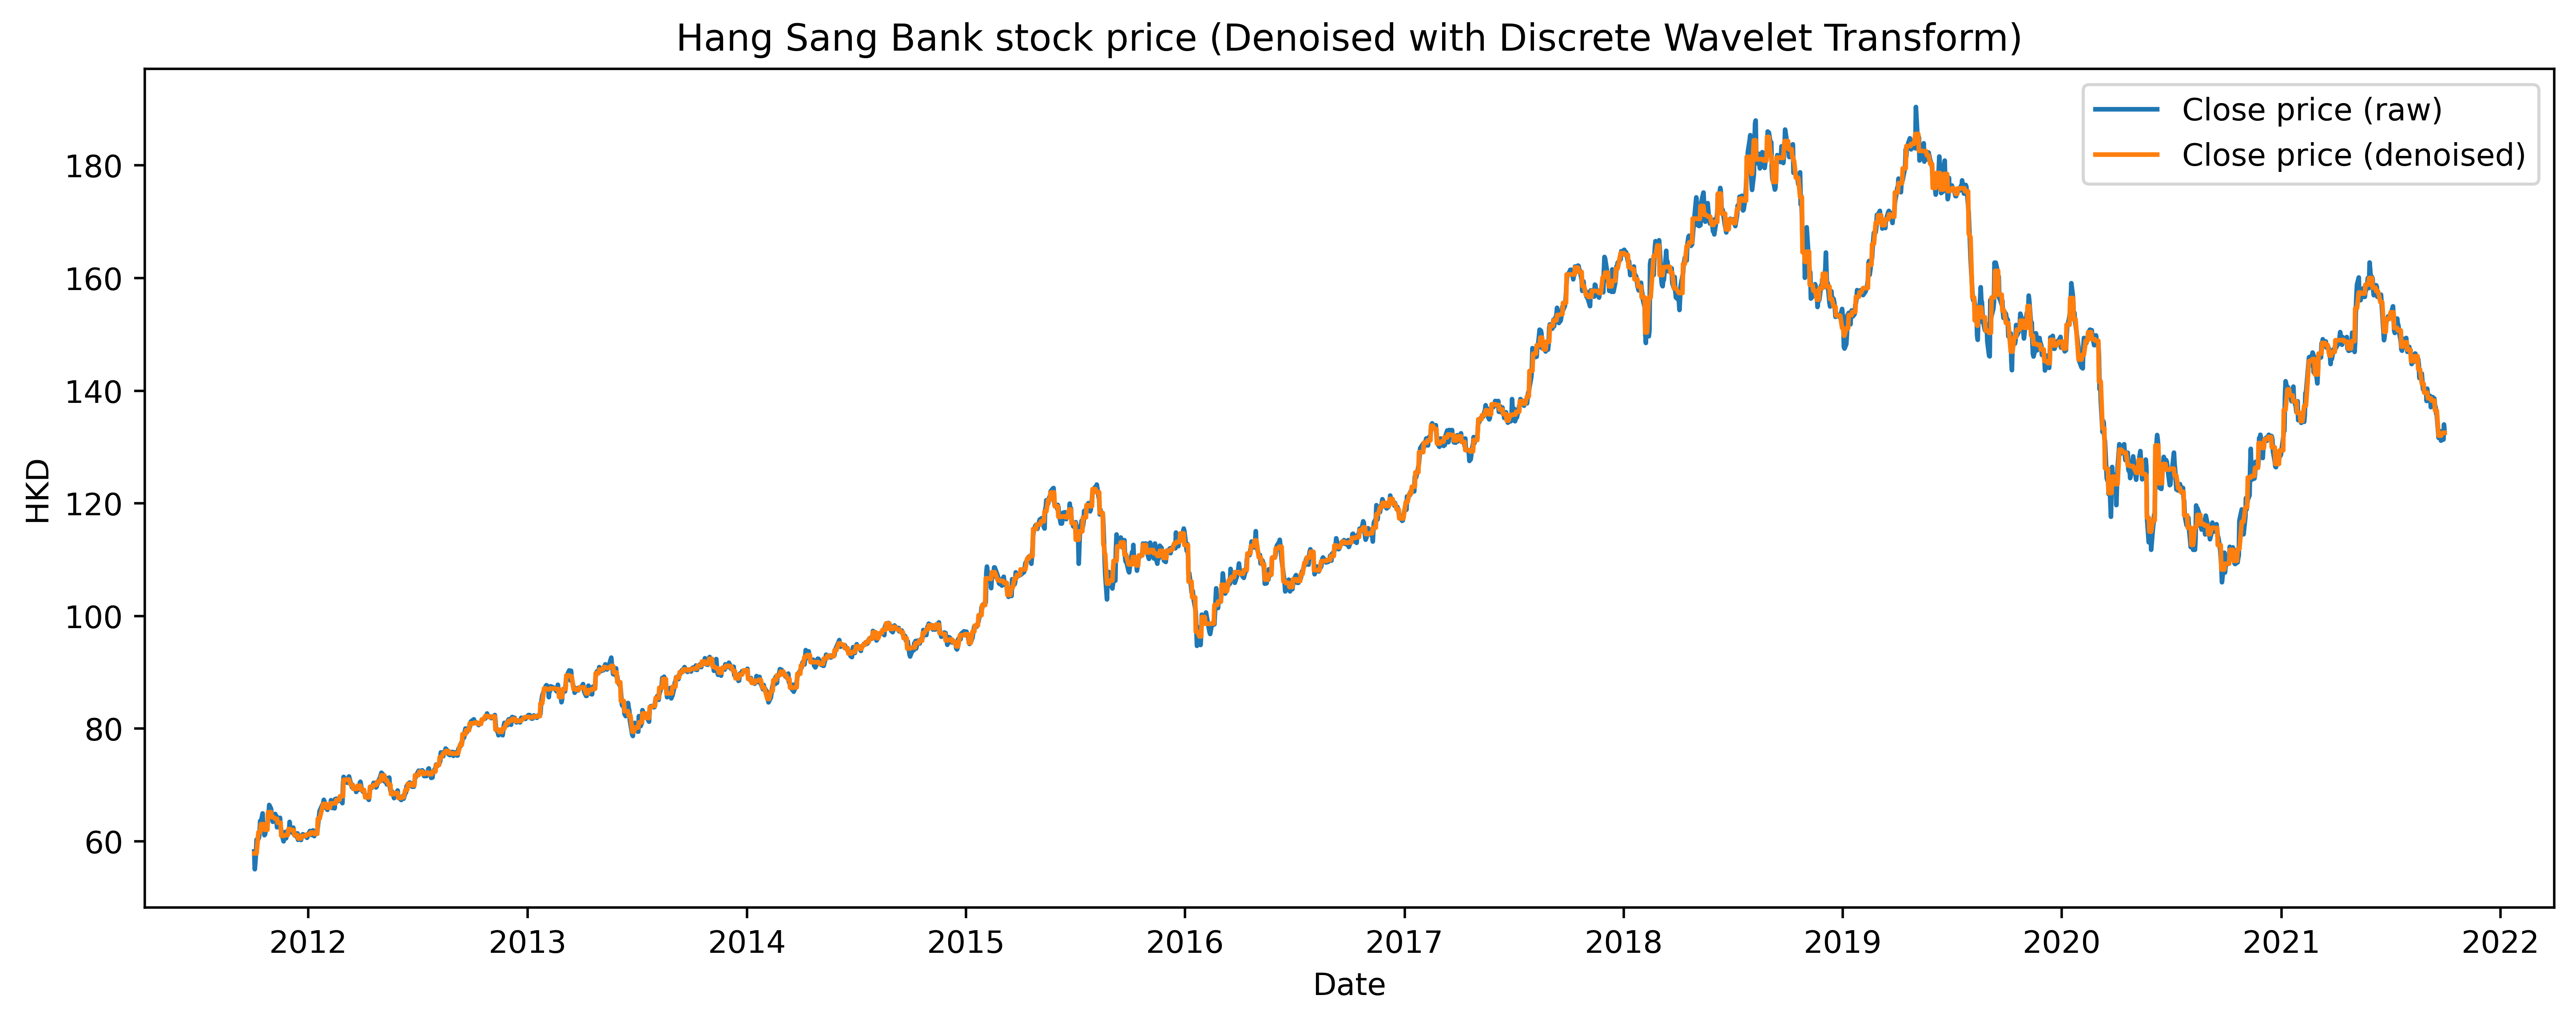

In [531]:
# plot the wavelet transformed (denoised)
def plot_wavelet_transformed_price(stock_index, title, raw_price_legend_label, denoised_price_legend_label, price_currency):
    if not isinstance(d_denoised[stock_index]["Date"][0], datetime):
        d_denoised[stock_index]["Date"] = d_denoised[stock_index]["Date"].apply(parse_string_to_datetime)

    plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
    plt.plot(d[stock_index]['Date'], d[stock_index]['Close'], label=raw_price_legend_label)
    plt.plot(d_denoised[stock_index]['Date'], d_denoised[stock_index]['Close'], label=denoised_price_legend_label)
    # plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.xlabel('Date')
    plt.ylabel(price_currency)
    plt.title(title)
    plt.legend()
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
    plt.show()

# plot the wavelet transformed (denoised) of Walt Disney Stock
plot_wavelet_transformed_price("DIS",
                               'The Walt Disney Company stock price (Denoised with Discrete Wavelet Transform)',
                               'Close price (raw)',
                               "Close price (denoised)",
                               'USD'
                            )
plot_wavelet_transformed_price("0011.HK",
                               'Hang Sang Bank stock price (Denoised with Discrete Wavelet Transform)',
                               'Close price (raw)',
                               "Close price (denoised)",
                               'HKD'
                            )

### Feature Extraction
##### using the ta library https://github.com/bukosabino/ta

In [532]:
d_feat_extr = copy.deepcopy(d_denoised) # create copy to prevent overwrite
d_feat_extr["DIS"]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2011-09-30,26.557592,27.041898,26.407898,26.533380,15135000,0.0,0
1,2011-10-03,26.443124,26.707291,25.527344,26.533380,13899200,0.0,0
2,2011-10-04,25.298400,26.390290,24.822900,26.533380,19000000,0.0,0
3,2011-10-05,26.724900,27.781567,26.689677,26.533380,17823700,0.0,0
4,2011-10-06,27.499790,28.221847,27.314874,28.472806,12659400,0.0,0
...,...,...,...,...,...,...,...,...
2512,2021-09-24,175.300003,176.699997,175.080002,175.364998,5712800,0.0,0
2513,2021-09-27,176.630005,179.449997,175.960007,175.364998,7755000,0.0,0
2514,2021-09-28,177.750000,178.000000,173.860001,175.364998,9133100,0.0,0
2515,2021-09-29,174.250000,174.960007,172.589996,175.364998,6240800,0.0,0


##### Accumulation Distribution (ACD)


In [533]:
acded_count = 0
for i in range(len(fns)):
    adi_tmp = d_feat_extr[fns[i]]
    adi = AccDistIndexIndicator(
        high=adi_tmp["High"],
        low=adi_tmp["Low"],
        close=adi_tmp["Close"],
        volume=adi_tmp["Volume"]
    )
    d_feat_extr[fns[i]]["ACD"] = adi.acc_dist_index()
    acded_count = acded_count + 1
    print("{} ACD OK".format(fns[i]))

print("ACD calculation finished, Count: {}".format(acded_count))


UAL ACD OK
1109.HK ACD OK
V ACD OK
2313.HK ACD OK
0027.HK ACD OK
3968.HK ACD OK
WU ACD OK
MSI ACD OK
FCX ACD OK
0003.HK ACD OK
ADM ACD OK
0011.HK ACD OK
GPN ACD OK
0857.HK ACD OK
ARE ACD OK
0001.HK ACD OK
0101.HK ACD OK
FMC ACD OK
AIZ ACD OK
BXP ACD OK
1398.HK ACD OK
0005.HK ACD OK
0941.HK ACD OK
0066.HK ACD OK
2331.HK ACD OK
0017.HK ACD OK
1093.HK ACD OK
0388.HK ACD OK
2319.HK ACD OK
0762.HK ACD OK
2628.HK ACD OK
1044.HK ACD OK
RL ACD OK
0241.HK ACD OK
FTNT ACD OK
JNPR ACD OK
DHI ACD OK
2020.HK ACD OK
EXPE ACD OK
1928.HK ACD OK
KO ACD OK
WDC ACD OK
LUMN ACD OK
UPS ACD OK
MSFT ACD OK
UDR ACD OK
COO ACD OK
2018.HK ACD OK
MLM ACD OK
0267.HK ACD OK
AMD ACD OK
ZBH ACD OK
0386.HK ACD OK
UHS ACD OK
SBAC ACD OK
0002.HK ACD OK
0669.HK ACD OK
LKQ ACD OK
PVH ACD OK
3988.HK ACD OK
GD ACD OK
CLX ACD OK
0688.HK ACD OK
DIS ACD OK
0883.HK ACD OK
LDOS ACD OK
LEN ACD OK
2382.HK ACD OK
AOS ACD OK
OMC ACD OK
1299.HK ACD OK
TSLA ACD OK
TXT ACD OK
1177.HK ACD OK
0012.HK ACD OK
0939.HK ACD OK
0960.HK ACD OK

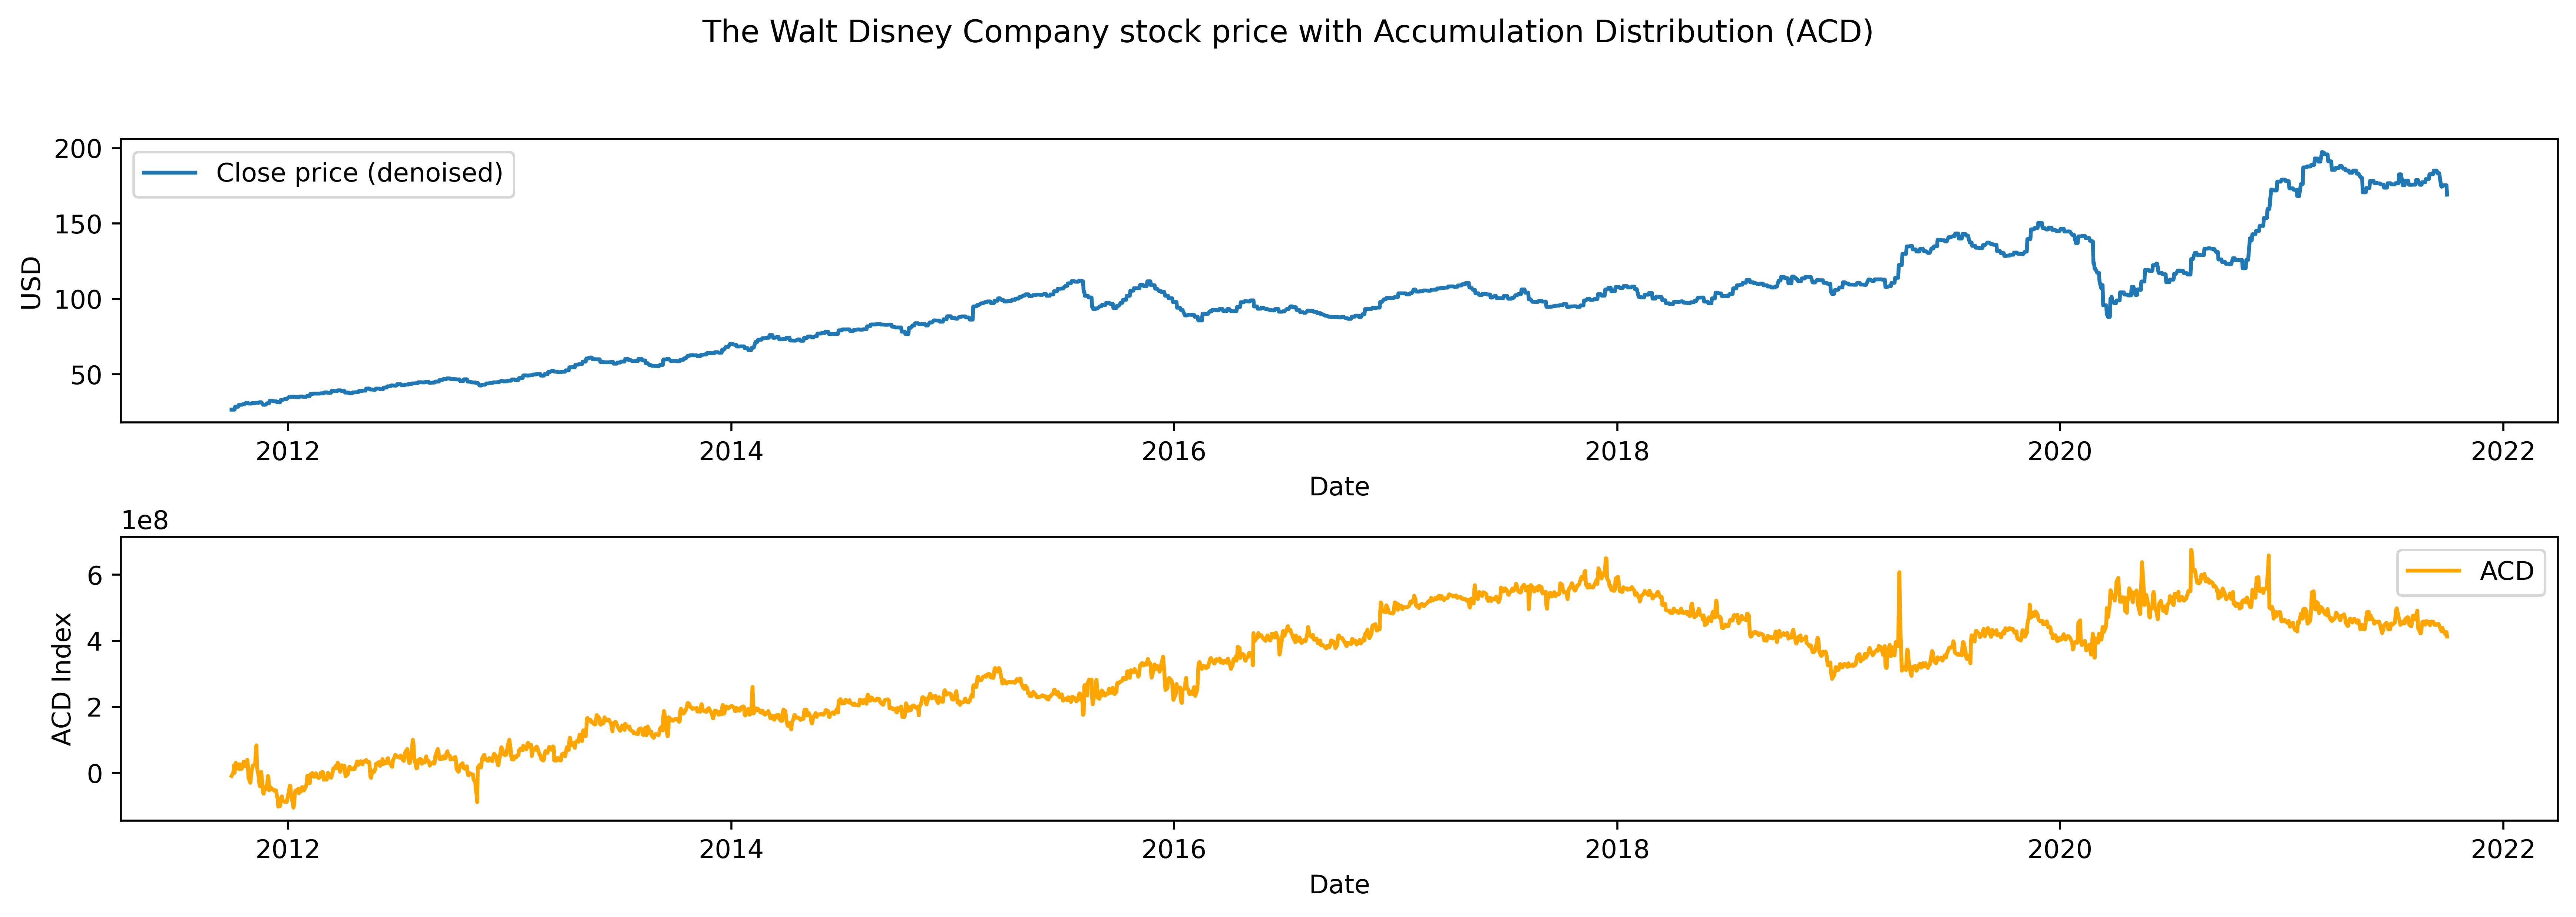

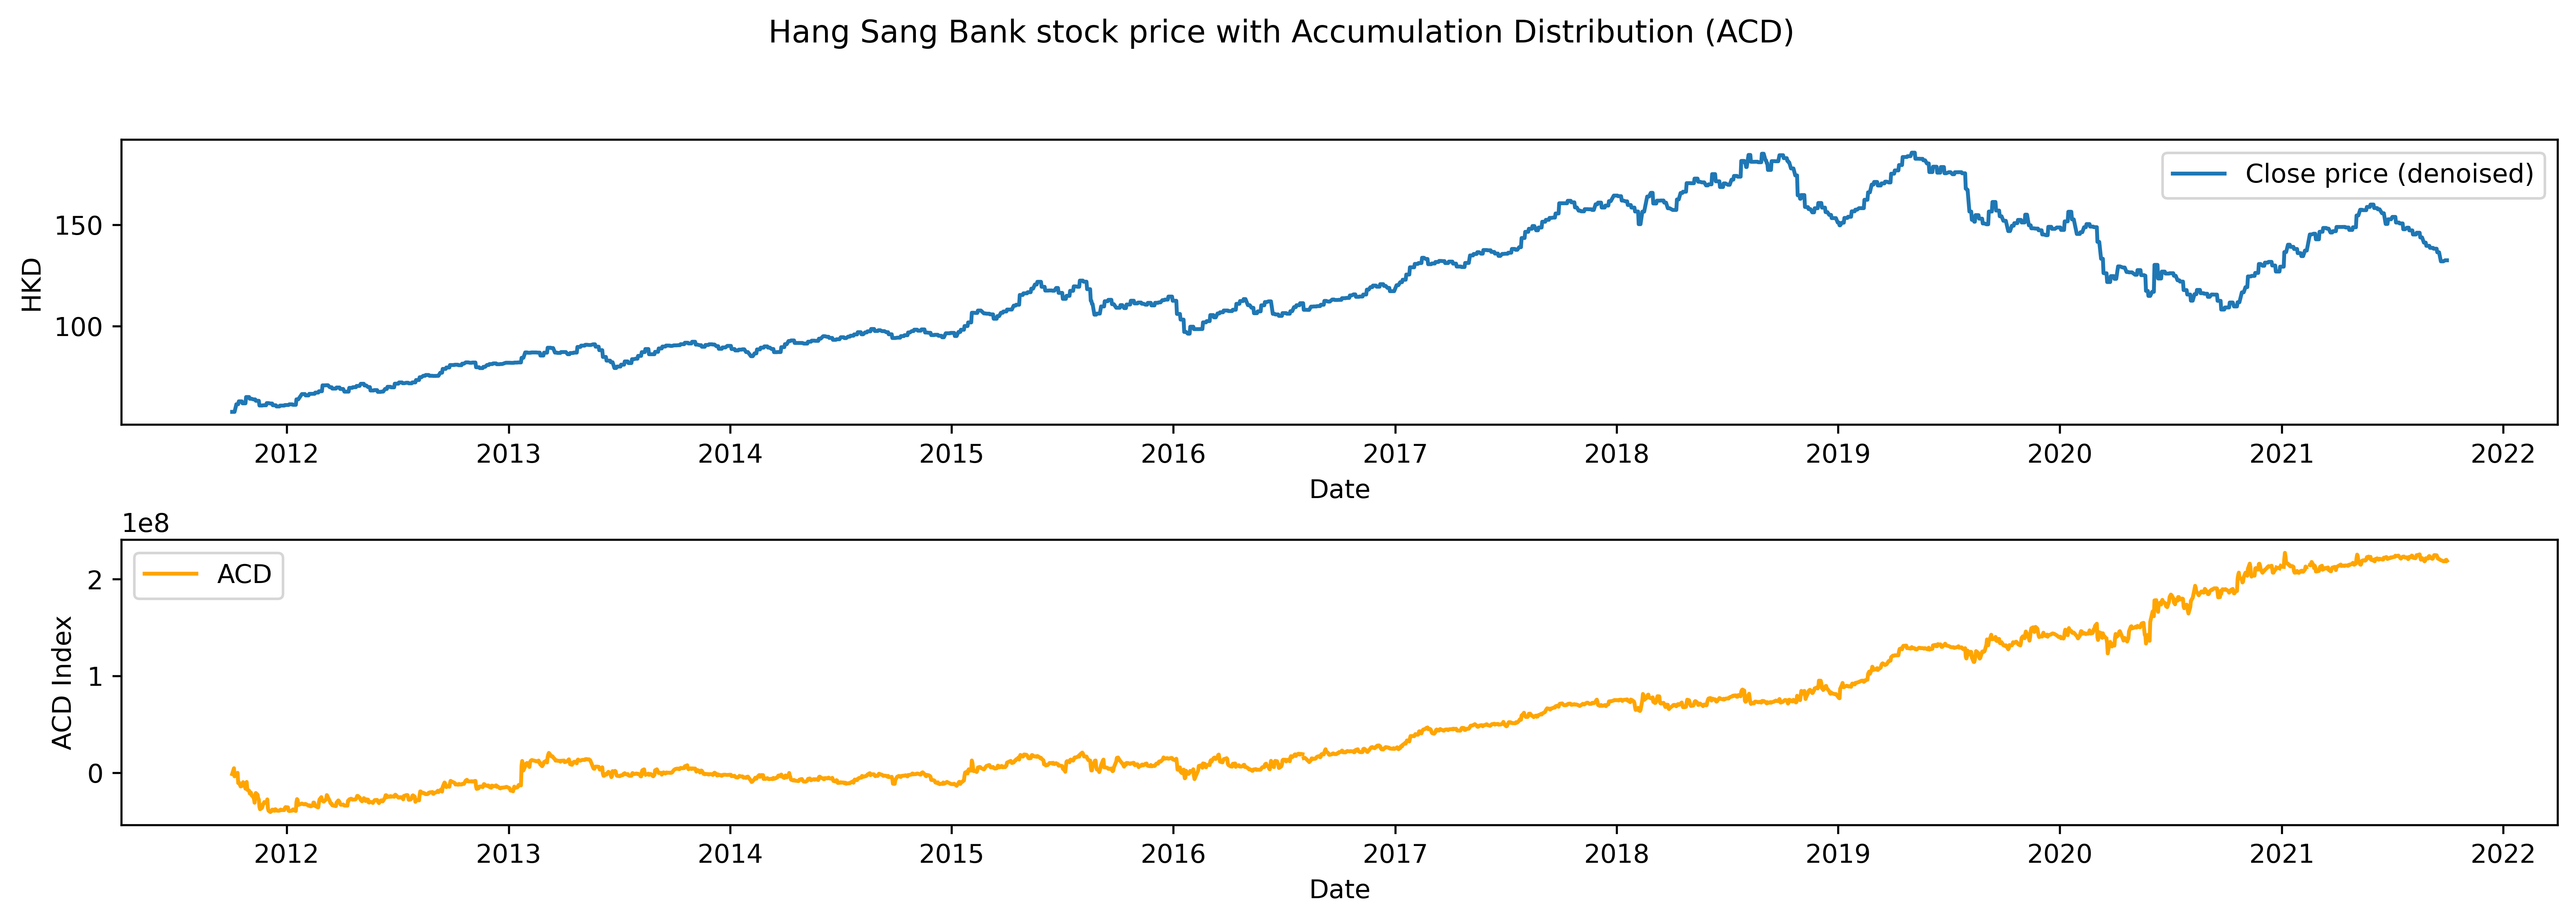

In [534]:
# plot Accumulation Distribution (ACD) line plots
def plot_acd_index(stock_id, plot_title, stock_price_legend_label, acd_legend_label, price_currency):
    if not isinstance(d_feat_extr[stock_id]["Date"][0], datetime):
        d_feat_extr[stock_id]["Date"] = d_feat_extr[stock_id]["Date"].apply(parse_string_to_datetime)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 5), dpi=500, facecolor="white")
    ax1.plot(d_feat_extr[stock_id]['Date'], d_feat_extr[stock_id]['Close'], label=stock_price_legend_label)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(price_currency)
    ax1.legend()

    ax2.plot(d_feat_extr[stock_id]['Date'], d_feat_extr[stock_id]['ACD'], label=acd_legend_label, color="orange")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('ACD Index')
    ax2.legend()

    fig.tight_layout()
    fig.suptitle(plot_title)
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.subplots_adjust(top=0.85)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, fig._suptitle.get_text()))
    plt.show()

plot_acd_index("DIS",
               "The Walt Disney Company stock price with Accumulation Distribution (ACD)",
               'Close price (denoised)',
               'ACD',
               'USD'
            )
plot_acd_index("0011.HK",
               "Hang Sang Bank stock price with Accumulation Distribution (ACD)",
               'Close price (denoised)',
               'ACD',
               'HKD'
            )

##### Moving Average Convergence Divergence (MACD)

In [535]:
#MACD line
#MACD signal line
#MACD Diff

#TODO: Also plot a MACD lines, and histogram for MACD diff

##### On-balance Volume (OBV)

##### The upper, middle, and lower band of the Bollinger Bands